# Статистический анализ данных сервиса аренды самокатов

**Цель проекта:** на основе переданных данных о некоторых пользователях из нескольких городов, а также об их поездках, необходимо сделать анализ сервиса аренды самокатов и проверить некоторые гипотезы.

#### Шаг 1. Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom

df1 = pd.read_csv('/datasets/users_go.csv')
df2 = pd.read_csv('/datasets/rides_go.csv')
df3 = pd.read_csv('/datasets/subscriptions_go.csv')

display(df1)
print(df1.info())
display(df2)
print(df2.info())
display(df3)
print(df3.info())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


#### Шаг 2. Предобработка данных

Необходимо привести столбец `date` к типу даты pandas, создать новый столбец с номером месяца на основе столбца `date`.
Также нужно проверить наличие пропущенных значений и дубликатов в датафреймах и обработать их, если такие значения присутствуют.

Дополнительно переведём значения столбца `distance` в километры, а также округлим значения столбцов `distance` и `round` до двух знаков после запятой.

In [2]:
df2['date'] = pd.to_datetime(df2['date'], yearfirst=True)
df2['distance'] = round(df2['distance'] / 1000, 2)
df2['duration'] = round(df2['duration'], 2)
df2['month'] = df2['date'].astype('datetime64[M]')
display(df2)
print(df2.info())

,user_id,distance,duration,date,month
0,1,4.41,25.60,2021-01-01,2021-01-01
1,1,2.62,15.82,2021-01-18,2021-01-01
2,1,0.75,6.23,2021-04-20,2021-04-01
3,1,2.69,18.51,2021-08-11,2021-08-01
4,1,4.03,26.27,2021-08-28,2021-08-01
...,...,...,...,...,...
18063,1534,3.78,19.82,2021-11-04,2021-11-01
18064,1534,2.84,21.41,2021-11-16,2021-11-01
18065,1534,3.83,18.44,2021-11-18,2021-11-01
18066,1534,2.90,16.67,2021-11-27,2021-11-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 705.9 KB
None


In [3]:
df1.drop_duplicates(inplace=True)
display(df1)
print(df1.info())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB
None


Предобработка данных выполнена: дубликаты в первом датафрейме удалены, необходимые манипуляции со столбцами выполнены. Пропуски во всех датафреймах отсутствуют.

---

#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках.

,city
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


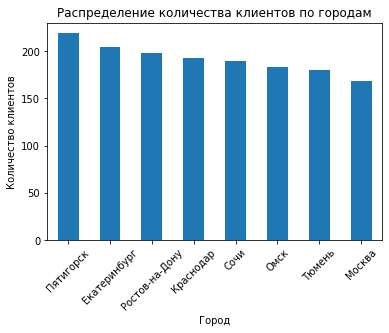

,subscription_type,percent
free,835,0.54
ultra,699,0.46


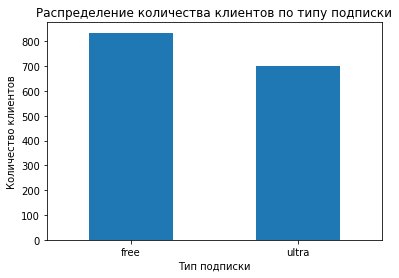

,age
count,1534.0
mean,24.9
median,25.0
max,43.0
min,12.0


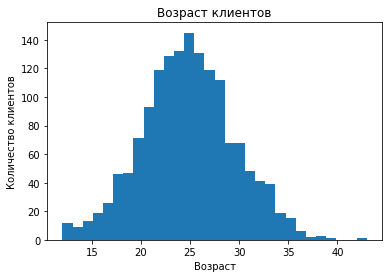

In [4]:
display(df1['city'].value_counts().to_frame())
(df1['city']
     .value_counts()
     .plot(kind='bar', title='Распределение количества клиентов по городам')
)
plt.xticks(rotation=45)
plt.ylabel('Количество клиентов')
plt.xlabel('Город')
plt.show()

sub = df1['subscription_type'].value_counts().to_frame()
sub['percent'] = round(sub['subscription_type'] / len(df1), 2)
display(sub)

(df1['subscription_type']
     .value_counts()
     .plot(kind='bar', title='Распределение количества клиентов по типу подписки')
)
plt.xticks(rotation=0)
plt.ylabel('Количество клиентов')
plt.xlabel('Тип подписки')
plt.show()

display(round(df1['age'].agg(['count', 'mean', 'median', 'max', 'min']), 2).to_frame())
df1['age'].plot(kind='hist', bins = 30, title='Возраст клиентов')
plt.ylabel('Количество клиентов')
plt.xlabel('Возраст')
plt.show()

,distance,duration
count,18068.00,18068.00
mean,3.07,17.81
median,3.13,17.68
max,7.21,40.82
min,0.00,0.50


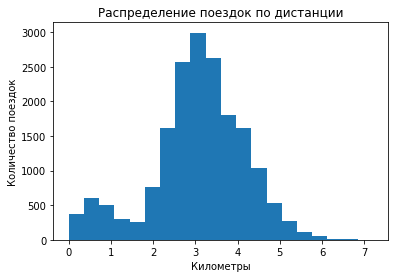

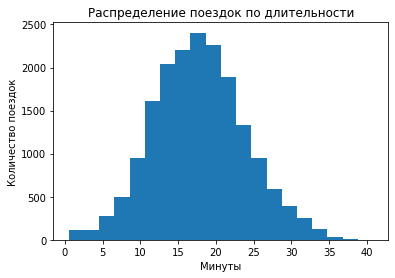

In [5]:
display(round(df2[['distance', 'duration']].agg(['count', 'mean', 'median', 'max', 'min']), 2))
df2['distance'].plot(kind='hist', bins = 20, title='Распределение поездок по дистанции')
plt.ylabel('Количество поездок')
plt.xlabel('Километры')
plt.show()

df2['duration'].plot(kind='hist', bins = 20, title='Распределение поездок по длительности')
plt.ylabel('Количество поездок')
plt.xlabel('Минуты')
plt.show()

Рассмотрим подробнее пики на графике дистанции:

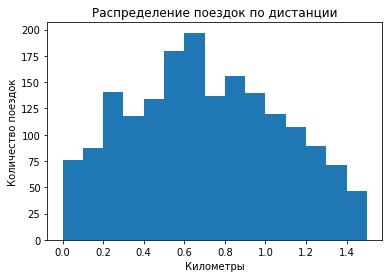

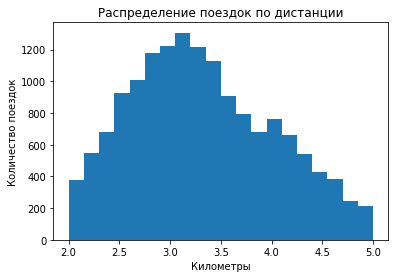

In [6]:
df2['distance'].plot(kind='hist', bins = 15, range=(0, 1.5), title='Распределение поездок по дистанции')
plt.ylabel('Количество поездок')
plt.xlabel('Километры')
plt.show()

df2['distance'].plot(kind='hist', bins = 20, range=(2, 5), title='Распределение поездок по дистанции')
plt.ylabel('Количество поездок')
plt.xlabel('Километры')
plt.show()

**Промежуточные выводы:**

* Наибольшее количество пользователей находится в Пятигорске (218 чел.), наименьшее - в Москве (168 чел.);
* Количество обладателей платной подписки почти равно количеству обычных пользователей (46% и 54% соответственно);
* Средний возраст пользователя - 25 лет, минимальный - 12, максимальный - 43;

При исследовании дальности и продолжительности поездок обнаружены аномальные значения (дистанция от 0 м до 1 км, время поездки - 0,5 с). Возможно, это связано с тем, что пользователи передумывали начинать поездку, закончились средства на балансе, самокаты по какой-либо причине были не пригодны для поездки. В то же время распределения данных величин выглядят корректно, медианы практически совпадают со средними значениями.

---

#### Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм. Проанализируем данные о пользователях без подписки и с подпиской. Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [7]:
df = df1.merge(df2).copy()

display(df)
df.info()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4.41,25.60,2021-01-01,2021-01-01
1,1,Кира,22,Тюмень,ultra,2.62,15.82,2021-01-18,2021-01-01
2,1,Кира,22,Тюмень,ultra,0.75,6.23,2021-04-20,2021-04-01
3,1,Кира,22,Тюмень,ultra,2.69,18.51,2021-08-11,2021-08-01
4,1,Кира,22,Тюмень,ultra,4.03,26.27,2021-08-28,2021-08-01
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3.78,19.82,2021-11-04,2021-11-01
18064,1534,Альберт,25,Краснодар,free,2.84,21.41,2021-11-16,2021-11-01
18065,1534,Альберт,25,Краснодар,free,3.83,18.44,2021-11-18,2021-11-01
18066,1534,Альберт,25,Краснодар,free,2.90,16.67,2021-11-27,2021-11-01


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 1.4+ MB


Анализ клиентов с подпиской free:


,distance,duration
count,11568.00,11568.00
mean,3.05,17.39
median,3.11,17.33
max,7.21,34.95
min,0.00,0.50


Анализ клиентов с подпиской ultra:


,distance,duration
count,6500.00,6500.00
mean,3.12,18.54
median,3.15,18.18
max,5.70,40.82
min,0.24,3.76


Распределение дистанции:


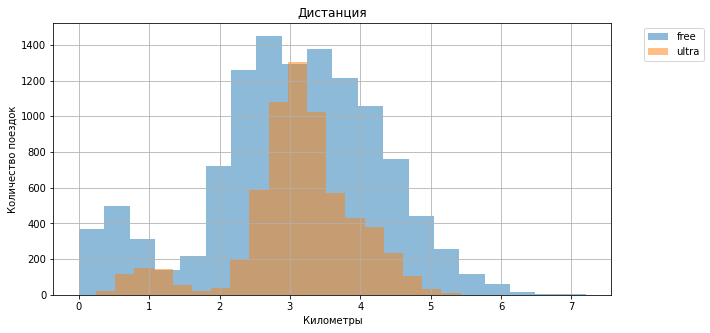

Распределение времени:


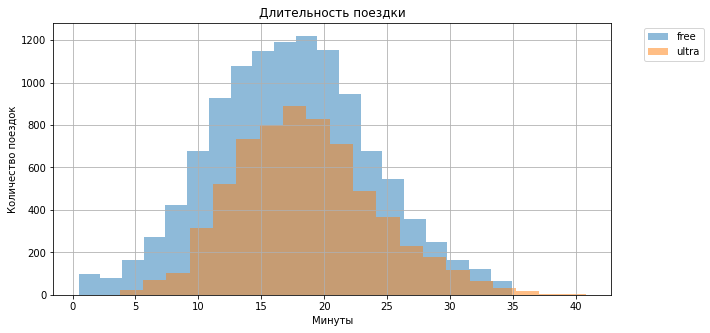

In [8]:
print('Анализ клиентов с подпиской free:')
display(round(df.query('subscription_type == "free"')[['distance', 'duration']] \
              .agg(['count', 'mean', 'median', 'max', 'min']), 2))

print('Анализ клиентов с подпиской ultra:')
display(round(df.query('subscription_type == "ultra"')[['distance', 'duration']] \
              .agg(['count', 'mean', 'median', 'max', 'min']), 2))

#график дистанций:

print('Распределение дистанции:')

df.query('subscription_type == "free"')['distance']\
  .plot(kind='hist', bins = 20, figsize=(10, 5), alpha=0.5)

df.query('subscription_type == "ultra"')['distance']\
  .plot(kind='hist', bins = 20,  alpha=0.5)

plt.grid()
plt.title('Дистанция')
plt.ylabel('Количество поездок')
plt.xlabel('Километры')
plt.legend(['free', 'ultra'], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#график времени:

print('Распределение времени:')

df.query('subscription_type == "free"')['duration']\
  .plot(kind='hist', bins = 20, figsize=(10, 5), alpha=0.5)

df.query('subscription_type == "ultra"')['duration']\
  .plot(kind='hist', bins = 20,  alpha=0.5)

plt.grid()
plt.title('Длительность поездки')
plt.ylabel('Количество поездок')
plt.xlabel('Минуты')
plt.legend(['free', 'ultra'], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

**Промежуточные выводы:**

* количество "премиальных" поездок составляет приблизительно 30% от общего числа;
* количество аномальных "сверхбыстрых" и "сверхкоротких" поездок сохраняется в обеих категориях, в остальном данные распределения выглядят коректно;
* средняя и медианная дистанции практически одинаковы в обеих категориях (около 3,1 км);
* средняя и медианная продолжительность поездки выше в категории "ultra" почти на 1 минуту.

---

#### Шаг 5. Подсчёт выручки

Создадим сводную таблицу с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4. Необходимо посчитать суммарное расстояние, количество поездок, суммарное время и выручку по каждому пользователю помесячно.

Далее, с помощью команды `merge()` добавим информацию по тарифам, после расчёта помесячной выручки удалим данную инфрмацию.

Помесячная выручка считается по формуле: стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

In [9]:
df['duration_ceil'] = np.ceil(df['duration'])

pvt = df.pivot_table(index=['user_id', 'subscription_type', 'month'], values=['distance', 'duration_ceil'], \
                     aggfunc=['count', 'sum']).copy()
pvt.columns = ['_'.join(col).strip() for col in pvt.columns.values]
pvt.rename(columns={'count_duration_ceil': 'count'}, inplace=True)

pvt.reset_index(inplace=True)
pvt = pvt.merge(df3, how='left')
pvt['month_rev'] = (pvt['start_ride_price'] + pvt['minute_price'] * pvt['sum_duration_ceil'] + pvt['subscription_fee']).astype('int')
pvt.drop(columns=['count_distance', 'minute_price', 'start_ride_price', 'subscription_fee'], inplace=True)
pvt.set_index(['user_id', 'subscription_type', 'month'], drop=True, inplace=True)
display(pvt)

count  sum_distance  sum_duration_ceil  \
user_id subscription_type month                                                
1       ultra             2021-01-01      2          7.03               42.0   
                          2021-04-01      1          0.75                7.0   
                          2021-08-01      2          6.72               46.0   
                          2021-10-01      2          5.81               32.0   
                          2021-11-01      3          7.00               56.0   
...                                     ...           ...                ...   
1534    free              2021-06-01      2          3.41               26.0   
                          2021-08-01      2          7.62               48.0   
                          2021-09-01      1          4.93               23.0   
                          2021-11-01      4         13.35               78.0   
                          2021-12-01      1          2.37               16.0   

                                      month_rev  
user_id subscription_type month                  
1       ultra             2021-01-01        451  
                          2021-04-01        241  
                          2021-08-01        475  
                          2021-10-01        391  
                          2021-11-01        535  
...                                         ...  
1534    free              2021-06-01        258  
                          2021-08-01        434  
                          2021-09-01        234  
                          2021-11-01        674  
                          2021-12-01        178  

[11331 rows x 4 columns]

**Промежуточный вывод:**

Подготовлена сводная таблица, необходимые данные добавлены.

---

#### Шаг 6. Проверка гипотез

*1 гипотеза:* нулевая - пользователи с подпиской и без подписки в среднем тратят одинаковое время на поездки. Альтернативная - пользователи с подпиской в среднем тратят больше времени на поездки, чем пользователи без подписки.

*2 гипотеза:* нулевая - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров. альтернативная - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров.

*3 гипотеза:* нулевая - средняя помесячная выручка от пользователей с подпиской равна средней выручке с пользователей без подписки. Альтернативная - средняя помесячная выручка от пользователей с подпиской выше, чем средняя выручка от пользователей без подписки. Дополнительная гипотеза зеркальна альтернативной.

*4 гипотеза:* нулевая - количество обращений в техподдержку не изменилось. Альтернативная - количество обращений в техподдержку значимо снизилось.

In [10]:
#1st hypothesis

alpha = 0.05 

results = st.ttest_ind(
    df.query('subscription_type == "ultra"')['duration'], 
    df.query('subscription_type == "free"')['duration'],
    alternative='greater',
    equal_var=False)

print('Первая гипотеза:')
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

print()    
print('Анализ клиентов с подпиской free:')
display(round(df.query('subscription_type == "free"')['duration'] \
              .agg(['count', 'mean', 'median']), 2).to_frame())

print('Анализ клиентов с подпиской ultra:')
display(round(df.query('subscription_type == "ultra"')['duration'] \
              .agg(['count', 'mean', 'median']), 2).to_frame())

Первая гипотеза:
p-value: 5.6460360110885e-37
Отвергаем нулевую гипотезу

Анализ клиентов с подпиской free:


,duration
count,11568.00
mean,17.39
median,17.33


Анализ клиентов с подпиской ultra:


,duration
count,6500.00
mean,18.54
median,18.18


In [11]:
#2nd hypothesis

interested_value = 3.13

results = st.ttest_1samp(
    df.query('subscription_type == "ultra"')['distance'], 
    interested_value,
    alternative='greater')

print('Вторая гипотеза:')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

display(round(df.query('subscription_type == "ultra"')['distance'] \
              .agg(['count', 'mean', 'median']), 2).to_frame())    


Вторая гипотеза:
p-значение: 0.9199218607432119
Нет оснований отвергнуть нулевую гипотезу


,distance
count,6500.00
mean,3.12
median,3.15


In [12]:
#3d hypothesis

results = st.ttest_ind(pvt.query('subscription_type == "ultra"')['month_rev'],\
                       pvt.query('subscription_type == "free"')['month_rev'],\
                       alternative='greater', equal_var=False)

print('Третья гипотеза:')
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

results = st.ttest_ind(pvt.query('subscription_type == "ultra"')['month_rev'],\
                       pvt.query('subscription_type == "free"')['month_rev'],\
                       alternative='less', equal_var=False)

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

print()
print('ultra')

display(round(pvt.query('subscription_type == "ultra"')['month_rev'] \
              .agg(['count', 'mean', 'median']), 2).to_frame())  

print()
print('free')

display(round(pvt.query('subscription_type == "free"')['month_rev'] \
              .agg(['count', 'mean', 'median']), 2).to_frame())  

Третья гипотеза:
p-value: 1.4112152331254297e-213
Отвергаем нулевую гипотезу
p-value: 1.0
Нет оснований отвергнуть нулевую гипотезу

ultra


,month_rev
count,4533.00
mean,362.73
median,331.00



free


,month_rev
count,6798.00
mean,293.49
median,258.00


**Промежуточные выводы:**

* 1 гипотеза опровергается: вероятность того, что пользователи с подпиской в среднем тратят больше времени на поездки, чем пользователи без подписки, равна практически 100%. Это подтверждается средними и медианными данными продолжительностями поездок: значения выше в категории "ultra" почти на 1 минуту (посчитаны параметры обеих генеральных совокупностей). Следует отметить, что множества по мощности различаются, поэтому был применён параметр `equal_var=False`;
* 2 гипотеза подтверждается: вероятность того, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров или меньше, равна 92%;
* 3 гипотеза опровергается: вероятность того, что средняя помесячная выручка от пользователей с подпиской равна средней выручке с пользователей без подписки или меньше, равна практически 0%. Это подтверждается средними и медианными данными выручки. Следует отметить, что множества по мощности различаются, поэтому был применён параметр `equal_var=False`;
* для 4 гипотезы необходима односторонняя проверка средних двух генеральных совокупностей: нулевая гипотеза будет звучать как «между средними значениями двух совокупностей нет разницы, они равны», а альтернативная — среднее значение первой генеральной совокупности меньше среднего значения второй генеральной совокупности. Если нулевая гипотеза будет опровергнута, значит, обновление серверов не привело к необходимому эффекту.
---

#### Шаг 7. Распределения

7.1 Нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.


7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.



Чтобы получить вероятность продления 100 подписок, равную 0.9512064034722397 , необходимо сделать не менее 1170 рассылок.


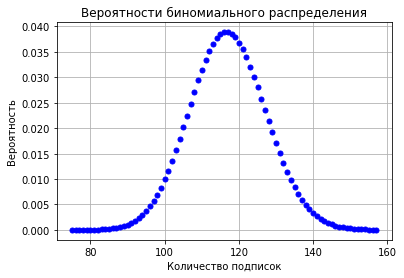

In [13]:
#7.1


n = 1170 # количество попыток
p = 0.1 # вероятность успеха
q = 1 - p # вероятность провала

sigma = (n*p*q)**(0.5)
distr = st.norm(n*p, sigma) 

x_0 = 100

result = 1 - distr.cdf(x_0)

print('Чтобы получить вероятность продления 100 подписок, равную', result, ', необходимо сделать не менее', n, 'рассылок.')

left = int(n * p - 4 * sigma)
right = int(n * p + 4 * sigma)
x = list(range(max(0, left), right))
ax = plt.subplot()
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5)
plt.grid()
plt.title('Вероятности биномиального распределения')
plt.ylabel('Вероятность')
plt.xlabel('Количество подписок')
plt.show()

Вероятность открытия менее 399.5 тысяч уведомлений: 0.15371708296369768
Для этого необходимо сделать 1000000 рассылок


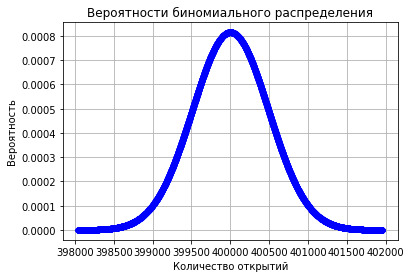

In [14]:
#7.2

n = 1000000 # количество рассылок
p = 0.4 # вероятность открытия
q = 1 - p # вероятность провала

mu = n * p
sigma = (n*p*q)**(0.5)
distr = st.norm(n*p, sigma) 

t = 399500 # ожидаемое количество открытий

result = distr.cdf(t)

print('Вероятность открытия менее 399.5 тысяч уведомлений:', result)
print('Для этого необходимо сделать', n, 'рассылок')

left = int(n * p - 4 * sigma)
right = int(n * p + 4 * sigma)
x = list(range(max(0, left), right))
ax = plt.subplot()
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5, label='вероятности биномиального распределения')
plt.grid()
plt.title('Вероятности биномиального распределения')
plt.ylabel('Вероятность')
plt.xlabel('Количество открытий')
plt.show()

**Промежутоные выводы:**

* Чтобы получить вероятность продления 100 подписок, равную 95%, необходимо сделать не менее 855 рассылок;
* Вероятность открытия менее 399.5 тысяч уведомлений составляет 15% при общем количестве рассылок 1000000.

---


#### Общие выводы

Данный проект заключается в анализе данных сервиса аренды самокатов и проверку некоторых гипотез.

Описание данных:

    user_id - уникальный идентификатор пользователя
    name - имя пользователя
    age - возраст
    city - город
    subscription_type - тип подписки (free, ultra)
    user_id - уникальный идентификатор пользователя
    distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
    duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» 
    до момента, как он нажал кнопку «Завершить поездку»
    date - дата совершения поездки
    subscription_type - тип подписки
    minute_price - стоимость одной минуты поездки по данной подписке
    start_ride_price - стоимость начала поездки
    subscription_fee - стоимость ежемесячного платежа

В ходе предобработки данных удалены дубликаты в первом датафрейме, столбец `date` приведён к типу даты pandas, создан новый столбец с номером месяца на основе столбца `date`. Дополнительно переведены значения столбца `distance` в километры, а также округлим значения столбцов `distance` и `round` до двух знаков после запятой. Пропуски во всех датафреймах отсутствуют.

После проведения исследовательского анализа данных были сделаны следующие заключения:

* Наибольшее количество пользователей находится в Пятигорске (218 чел.), наименьшее - в Москве (168 чел.);
* Количество обладателей платной подписки почти равно количеству обычных пользователей (46% и 54% соответственно);
* Средний возраст пользователя - 25 лет, минимальный - 12, максимальный - 43;
* количество "премиальных" поездок составляет приблизительно 30% от общего числа;
* количество аномальных "сверхбыстрых" и "сверхкоротких" поездок сохраняется в обеих категориях, в остальном данные распределения выглядят коректно;
* средняя и медианная дистанции практически одинаковы в обеих категориях (около 3,1 км);
* средняя и медианная продолжительность поездки выше в категории "ultra" почти на 1 минуту.

При исследовании дальности и продолжительности поездок обнаружены аномальные значения (дистанция - 0 м, время поездки - 0,5 с). Возможно, это связано с тем, что пользователи передумывали начинать поездку, закончились средства на балансе, самокаты по какой-либо причине были не пригодны для поездки. В то же время распределения данных величин выглядят корректно, медианы практически совпадают со средними значениями.

Для проверки гипотез подготовлена сводная таблица, в неё добавлены данные помесячной выручки.

В ходе проверки гипотез были получены следующие результаты:

* 1 гипотеза опровергается: вероятность того, что пользователи с подпиской в среднем тратят больше времени на поездки, чем пользователи без подписки, равна практически 100%. Это подтверждается средними и медианными данными продолжительностями поездок: значения выше в категории "ultra" почти на 1 минуту (посчитаны параметры обеих генеральных совокупностей);
* 2 гипотеза подтверждается: вероятность того, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров или меньше, равна 92%;
* 3 гипотеза опровергается: вероятность того, что средняя помесячная выручка от пользователей с подпиской равна средней выручке с пользователей без подписки или меньше, равна практически 0%. Это подтверждается средними и медианными данными выручки;
* для 4 гипотезы необходима односторонняя проверка средних двух генеральных совокупностей: нулевая гипотеза будет звучать как «между средними значениями двух совокупностей нет разницы, они равны», а альтернативная — среднее значение первой генеральной совокупности меньше среднего значения второй генеральной совокупности. Если нулевая гипотеза будет опровергнута, значит, обновление серверов не привело к необходимому эффекту.

**Итоговый вывод по гипотезам:** Несмотря на то, что пользователи с подпиской тратят больше времени на поездки, в большинстве случаев расстояние данных поездок менее оптимального с точки зрения износа самоката. К тому же анализ показал, что пользователь с подпиской гораздо прибыльнее для бизнеса. ***Рекомендуется увеличение охвата пользователей подписками.***

При создании дополнительных распределений получены следующие данные:

* Чтобы получить вероятность продления 100 подписок, равную 95%, необходимо сделать не менее 855 рассылок;
* Вероятность открытия менее 399.5 тысяч уведомлений составляет 15% при общем количестве рассылок 1000000.